In [1]:
import pandas as pd
import numpy as np
from collections import Counter 
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import copy
from tqdm import tqdm
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.feature_selection import f_regression

import sys 

sys.path.append('/home/groups/dpwall/briannac/blood_microbiome/src/abundance/')
from abundance_plots import AbundancePlotSettingsAndSave
from abundance_plots import abundance_plot_settings


BLOOD_MICROBIOME_DIR = '/home/groups/dpwall/briannac/blood_microbiome/'
F_REGRESSION_RESULTS = BLOOD_MICROBIOME_DIR + 'results/f_regression/f_regression_results.csv'
BAM_MAPPINGS_FILE = BLOOD_MICROBIOME_DIR + 'data/bam_mappings.csv'
bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)

MICROBE_FILE = BLOOD_MICROBIOME_DIR + 'data/kraken_align/microbe_filtered_species.tsv'
FIG_DIR = BLOOD_MICROBIOME_DIR + 'results/contaminants/'
df_microbe = pd.read_table(MICROBE_FILE, index_col=0).transpose()

In [2]:
f_regress_results = pd.read_csv(F_REGRESSION_RESULTS, header=None)
f_regress_results.drop(0, inplace=True, axis=1)
f_regress_results.columns = ['name', 'exog_value', 'coeff']
f_regress_results['coeff_abs'] = abs(f_regress_results.coeff)

In [3]:
# Microbes & viruses with no association w/sequencing plate.
set(df_microbe.columns).difference((set(f_regress_results[['sequencing_plate' in c for c in f_regress_results.exog_value]].name)))

{'Human betaherpesvirus 6A',
 'Human betaherpesvirus 6B',
 'Human betaherpesvirus 7',
 'Human erythrovirus V9',
 'Human mastadenovirus C',
 'Human respirovirus 3',
 'Lactococcus virus c2',
 'Murine leukemia virus',
 'Natronomonas sp. C90',
 'Primate erythroparvovirus 1',
 'Primate erythroparvovirus 3',
 'Pseudomonas tolaasii',
 'Squirrel monkey retrovirus',
 'Torque teno virus 13',
 'Torque teno virus 15',
 'Torque teno virus 20',
 'Torque teno virus 21',
 'Torque teno virus 24',
 'Torque teno virus 7',
 'Torque teno virus 8'}

In [4]:
# Read in data
bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)
df_microbe['sequencing_plate'] = bam_mappings.loc[[i.split(' ')[0] for i in df_microbe.index]].sequencing_plate.values
df_microbe['family'] = bam_mappings.loc[[i.split(' ')[0] for i in df_microbe.index]].family.values
df_microbe['bio_seq_source'] = bam_mappings.loc[[i.split(' ')[0] for i in df_microbe.index]].bio_seq_source.values
df_microbe['sample'] = df_microbe.index

In [5]:
# Set up hits.
hits = [(n,exog, coeff) for n,exog, coeff in zip(f_regress_results.name, f_regress_results.exog_value, f_regress_results.coeff)]
hits = sorted(hits, key=lambda x: abs(x[2]))[::-1]
seq_plate_hits = [h for h in hits if ('sequencing_plate' in h[1]) & ('nan' not in h[1]) & (h[2]>0)]
seq_plate_hits = [(i[0],i[1].replace('sequencing_plate_', ''), i[2]) for i in seq_plate_hits]
WB_hits = [h for h in hits if ('bio_seq_source' in h[1]) & ('nan' not in h[1]) & (h[2]>0)]
WB_hits = [(i[0],i[1].replace('bio_seq_source_', ''), i[2]) for i in WB_hits]

LCL_hits = [h for h in hits if ('bio_seq_source' in h[1]) & ('nan' not in h[1]) & (h[2]<0)]
LCL_hits = [(i[0],i[1].replace('bio_seq_source_', ''), i[2]) for i in LCL_hits]


In [6]:
colors = ["#8687d1", "#ff9900",  "#3b5c36"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

# Plotting

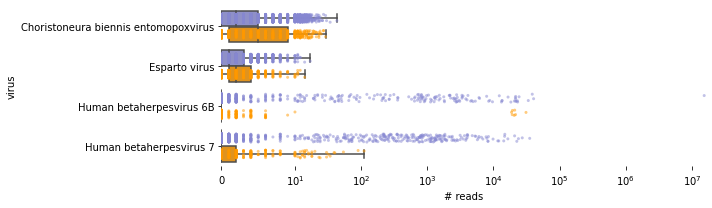

In [7]:
hit_microbes_WB = [i[0] for i in WB_hits if  ('virus' in i[0])]
df_melt = pd.melt(df_microbe[hit_microbes_WB + ['bio_seq_source', 'family', 'sample']], id_vars=['sample', 'family', 'bio_seq_source'])
df_melt.rename(columns={'variable': 'virus', 'value': '# reads'}, inplace=True)
df_melt = df_melt.sort_values('virus')

plt.figure(figsize=(10,3))
sns.boxplot(data=df_melt, x='# reads', y='virus', hue='bio_seq_source', hue_order=['LCL','WB'], fliersize=0, whis=100)#, jitter=.2)
sns.stripplot(data=df_melt, x='# reads', y='virus', hue='bio_seq_source', hue_order=['LCL','WB'], jitter=.2, dodge=True, alpha=.5, size=3)
abundance_plot_settings()
plt.savefig('%s/virus_associated_with_WB.svg' % FIG_DIR, 
            transparent=True, bbox_inches='tight')
plt.savefig('%s/virus_associated_with_WB.png' % FIG_DIR, 
            transparent=True, bbox_inches='tight', dpi=300)

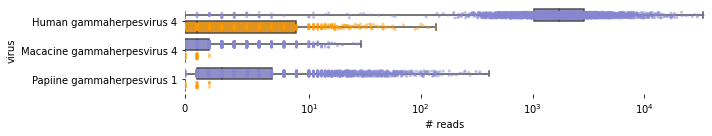

In [8]:
hit_microbes_LCL = [i[0] for i in LCL_hits if  ('virus' in i[0])]
df_melt = pd.melt(df_microbe[hit_microbes_LCL + ['bio_seq_source', 'family', 'sample']], id_vars=['sample', 'family', 'bio_seq_source'])
df_melt.rename(columns={'variable': 'virus', 'value': '# reads'}, inplace=True)
df_melt = df_melt.sort_values('virus')

plt.figure(figsize=(10,2))
sns.boxplot(data=df_melt, x='# reads', y='virus', hue='bio_seq_source', hue_order=['LCL','WB'], fliersize=0, whis=100)#, jitter=.2)
sns.stripplot(data=df_melt, x='# reads', y='virus', hue='bio_seq_source', hue_order=['LCL','WB'], jitter=.2, dodge=True, alpha=.5, size=3)
abundance_plot_settings()
plt.savefig('%s/virus_associated_with_LCL.svg' % FIG_DIR, 
            transparent=True, bbox_inches='tight')
plt.savefig('%s/virus_associated_with_LCL.png' % FIG_DIR, 
            transparent=True, bbox_inches='tight', dpi=300)

## Bacteria

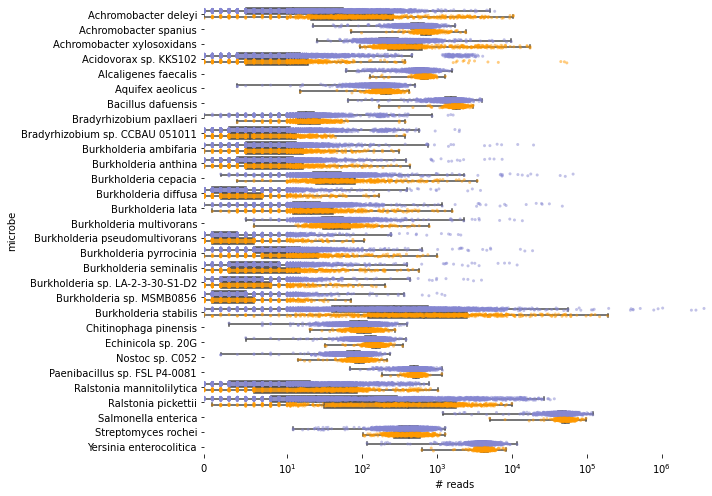

In [9]:
hit_microbes_WB = [i[0] for i in WB_hits if  ('virus' not in i[0])][:30]
df_melt = pd.melt(df_microbe[hit_microbes_WB + ['bio_seq_source', 'family', 'sample']], id_vars=['sample', 'family', 'bio_seq_source'])
df_melt.rename(columns={'variable': 'microbe', 'value': '# reads'}, inplace=True)
df_melt = df_melt.sort_values('microbe')

plt.figure(figsize=(10,7))
sns.boxplot(data=df_melt, x='# reads', y='microbe', hue='bio_seq_source', hue_order=['LCL','WB'], fliersize=0, whis=100)#, jitter=.2)
sns.stripplot(data=df_melt, x='# reads', y='microbe', hue='bio_seq_source', hue_order=['LCL','WB'], jitter=.2, dodge=True, alpha=.5, size=3)
abundance_plot_settings()
plt.savefig('%s/microbe_associated_with_WB.svg' % FIG_DIR, 
            transparent=True, bbox_inches='tight')
plt.savefig('%s/microbe_associated_with_WB.png' % FIG_DIR, 
            transparent=True, bbox_inches='tight', dpi=300)

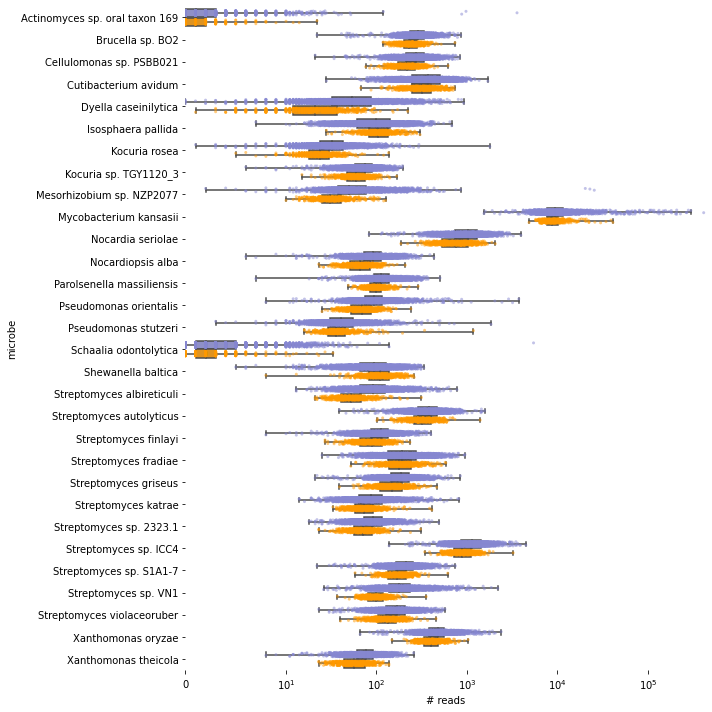

In [10]:
hit_microbes_LCL = [i[0] for i in LCL_hits if  ('virus' not in i[0])][:30]
df_melt = pd.melt(df_microbe[hit_microbes_LCL + ['bio_seq_source', 'family', 'sample']], id_vars=['sample', 'family', 'bio_seq_source'])
df_melt.rename(columns={'variable': 'microbe', 'value': '# reads'}, inplace=True)
df_melt = df_melt.sort_values('microbe')

plt.figure(figsize=(10,10))
sns.boxplot(data=df_melt, x='# reads', y='microbe', hue='bio_seq_source', hue_order=['LCL','WB'], fliersize=0, whis=100)#, jitter=.2)
sns.stripplot(data=df_melt, x='# reads', y='microbe', hue='bio_seq_source', hue_order=['LCL','WB'], jitter=.2, dodge=True, alpha=.5, size=3)
abundance_plot_settings()
plt.savefig('%s/microbe_associated_with_LCL.svg' % FIG_DIR, 
            transparent=True, bbox_inches='tight')
plt.savefig('%s/microbe_associated_with_LCL.png' % FIG_DIR, 
            transparent=True, bbox_inches='tight', dpi=300)

# Associated with Sequencing Plate

In [11]:
hit_microbes_batch = list({i[0] for i in seq_plate_hits if ('virus' in i[0])})
df_melt = pd.melt(df_microbe[hit_microbes_batch + ['sequencing_plate', 'family', 'sample']], id_vars=['sample', 'family', 'sequencing_plate'])
df_melt['in_batch'] = '0'
for microbe,b, coef in seq_plate_hits:
    if 'virus' in microbe:
        df_melt.loc[(df_melt.sequencing_plate==b) & (df_melt.variable==microbe),'in_batch']=b
df_melt.rename(columns={'variable': 'virus', 'value': 'read counts'}, inplace=True)
df_melt = df_melt.sort_values('virus')

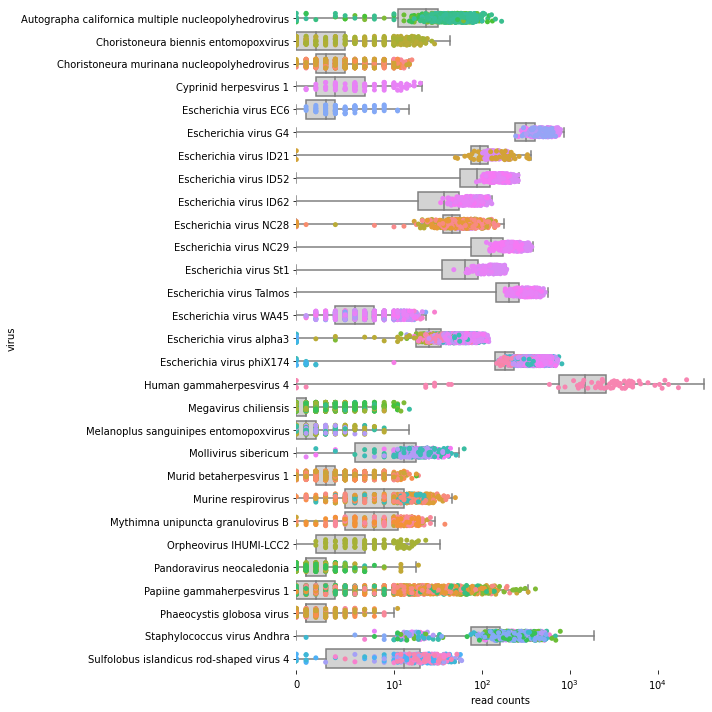

In [12]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df_melt[df_melt.in_batch=='0'], x='read counts', y='virus', color='#D3D3D3', fliersize=2, whis=100)#, jitter=.2)
sns.stripplot(data=df_melt[df_melt.in_batch!='0'], x='read counts', y='virus', hue='in_batch', 
              hue_order = sorted(list(np.unique(df_melt[df_melt.in_batch!='0'].in_batch.values))), jitter=.2)
abundance_plot_settings()
plt.savefig('%s/virus_associated_with_seq_plate.svg' % FIG_DIR, 
            transparent=True, bbox_inches='tight')#, format='png', dpi=500)
plt.savefig('%s/virus_associated_with_seq_plate.png' % FIG_DIR, 
            transparent=True, bbox_inches='tight', dpi=300)#, format='png', dpi=500)

## Bacteria

In [13]:
hit_microbes_batch = [i[0] for i in seq_plate_hits if ('virus' not in i[0])]
hit_microbes_batch = [hit_microbes_batch[i] for i in sorted(np.unique(hit_microbes_batch, return_index=True)[1])] ## Do this to maintain significance order!
print(len(hit_microbes_batch), 'associated w/batch')
hit_microbes_batch = hit_microbes_batch[:30]
df_melt = pd.melt(df_microbe[hit_microbes_batch + ['sequencing_plate', 'family', 'sample']], id_vars=['sample', 'family', 'sequencing_plate'])
df_melt['in_batch'] = '0'
for microbe,b, coef in seq_plate_hits:
    if microbe in hit_microbes_batch:
        df_melt.loc[(df_melt.sequencing_plate==b) & (df_melt.variable==microbe),'in_batch']=b
df_melt.rename(columns={'variable': 'microbe', 'value': '# reads'}, inplace=True)
df_melt = df_melt.sort_values('microbe')

1449 associated w/batch


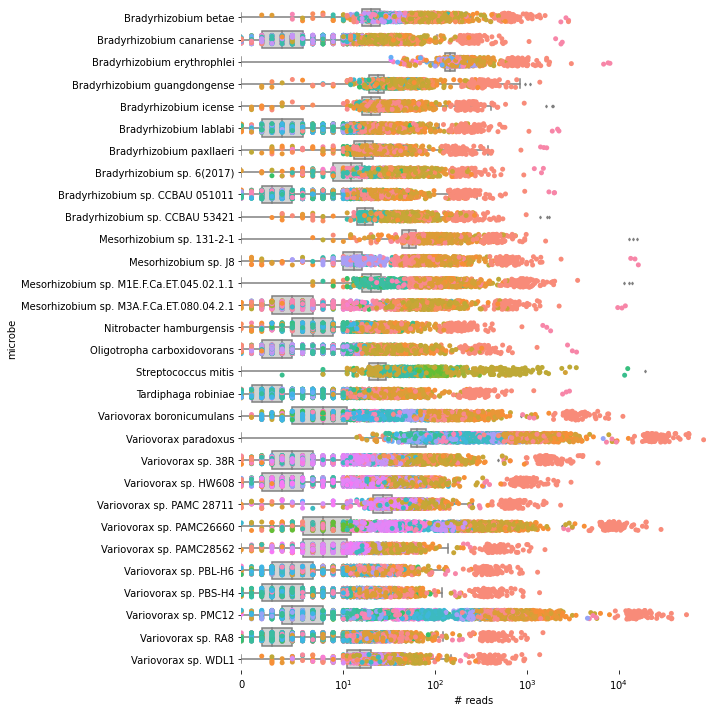

In [14]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df_melt[df_melt.in_batch=='0'], x='# reads', y='microbe', color='#D3D3D3', fliersize=2, whis=100)#, jitter=.2)
sns.stripplot(data=df_melt[df_melt.in_batch!='0'], x='# reads', y='microbe', hue='in_batch', 
              hue_order = sorted(list(np.unique(df_melt[df_melt.in_batch!='0'].in_batch.values))), jitter=.2)
abundance_plot_settings()
plt.savefig('%s/microbe_associated_with_seq_plate.svg' % FIG_DIR, 
            transparent=True, bbox_inches='tight')#, format='png', dpi=500)
plt.savefig('%s/microbe_associated_with_seq_plate.png' % FIG_DIR, 
            transparent=True, bbox_inches='tight', dpi=300)#, format='png', dpi=500)

## Bacteria

In [12]:
# Set up hits.
hits = [(bacteria_pvals.index[i],bacteria_pvals.columns[j]) for i,j in zip(r,c)]
seq_plate_hits = [h for h in hits if 'sequencing_plate' in h[1]]
seq_plate_hits = [(i[0],i[1].replace('sequencing_plate_', '')) for i in seq_plate_hits]
bio_source_hits = [h for h in hits if 'bio_seq_source' in h[1]]
bio_source_hits = [(i[0],i[1].replace('bio_seq_source_', '')) for i in bio_source_hits]

In [13]:
colors = ["#8687d1", "#ff9900",  "#3b5c36"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

# Plotting

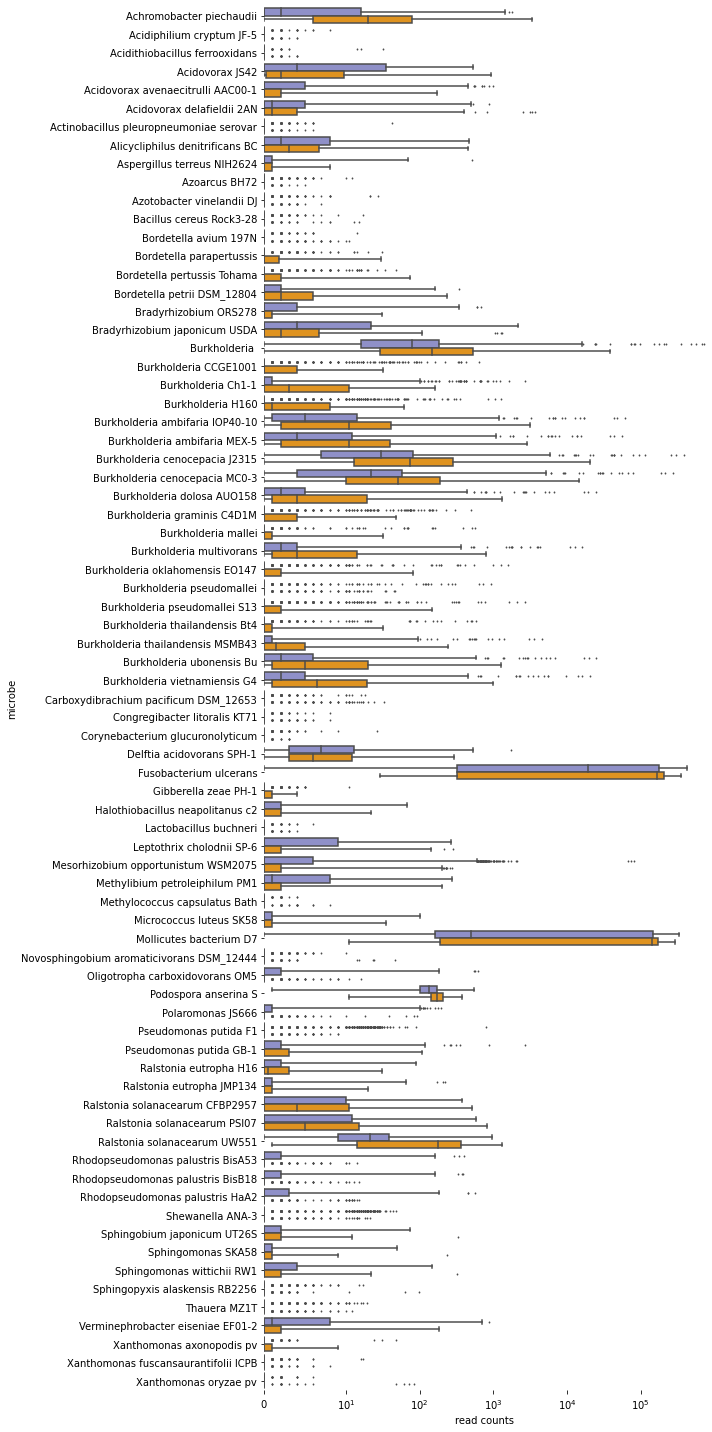

In [14]:
df_bacteria['sample'] = df_bacteria.index
hit_microbes_WB = [i[0] for i in bio_source_hits if i[1]=='WB']
df_melt = pd.melt(df_bacteria[hit_microbes_WB + ['bio_seq_source', 'family', 'sample']], id_vars=['sample', 'family', 'bio_seq_source'])
df_melt.rename(columns={'variable': 'microbe', 'value': 'read counts'}, inplace=True)
df_melt = df_melt.sort_values('microbe')

plt.figure(figsize=(10,20))
sns.boxplot(data=df_melt, x='read counts', y='microbe', hue='bio_seq_source', hue_order=['LCL','WB'], fliersize=1, whis=100)#, jitter=.2)
#sns.stripplot(data=df_melt, x='read counts', y='microbe', hue='bio_seq_source', hue_order=['LCL','WB'], jitter=.2)
abundance_plot_settings()
#plt.savefig('%s/virus_associated_with_WB.png' % fig_dir, 
#            transparent=True, bbox_inches='tight', format='png', dpi=500)

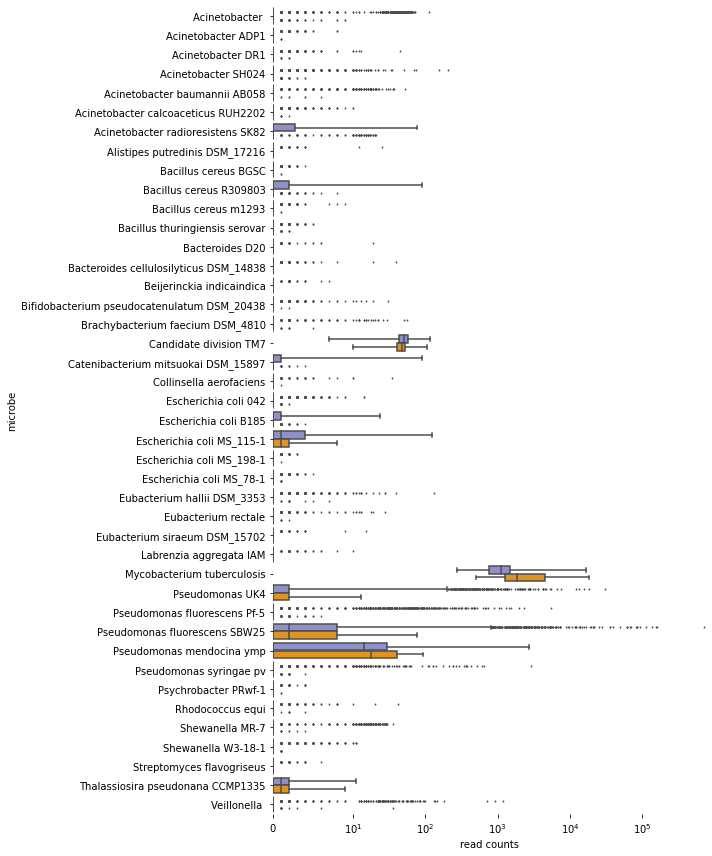

In [15]:
df_bacteria['sample'] = df_bacteria.index
hit_microbes_LCL = [i[0] for i in bio_source_hits if i[1]=='LCL']
df_melt = pd.melt(df_bacteria[hit_microbes_LCL + ['bio_seq_source', 'family', 'sample']], id_vars=['sample', 'family', 'bio_seq_source'])
df_melt.rename(columns={'variable': 'microbe', 'value': 'read counts'}, inplace=True)
df_melt = df_melt.sort_values('microbe')

plt.figure(figsize=(10,12))
sns.boxplot(data=df_melt, x='read counts', y='microbe', hue='bio_seq_source', hue_order=['LCL','WB'], fliersize=1, whis=100)#, jitter=.2)
#sns.stripplot(data=df_melt, x='read counts', y='microbe', hue='bio_seq_source', hue_order=['LCL','WB'], jitter=.2)
abundance_plot_settings()
#plt.savefig('%s/virus_associated_with_WB.png' % fig_dir, 
#            transparent=True, bbox_inches='tight', format='png', dpi=500)

In [34]:
len(set(df_bacteria['sequencing_plate']))

54

In [37]:
Counter([s[0] for s in seq_plate_hits]).most_common(10)

[('Mycobacterium tuberculosis', 47),
 ('Plasmodium knowlesi strain', 47),
 ('Delftia acidovorans SPH-1', 45),
 ('Chaetomium globosum CBS', 43),
 ('Fusobacterium ulcerans', 43),
 ('Leishmania major strain', 43),
 ('Mollicutes bacterium D7', 43),
 ('Streptomyces C', 43),
 ('Dictyostelium discoideum AX4', 42),
 ('Podospora anserina S', 42)]

In [42]:
seq_plate_hits_small = seq_plate_hits[:500]
hit_microbes_batch = list({i[0] for i in seq_plate_hits_small})
df_melt = pd.melt(df_bacteria[hit_microbes_batch + ['sequencing_plate', 'family', 'sample']], id_vars=['sample', 'family', 'sequencing_plate'])
df_melt['in_batch'] = '0'
for microbe,b in tqdm(seq_plate_hits_small):
    df_melt.loc[(df_melt.sequencing_plate==b) & (df_melt.variable==microbe),'in_batch']='1'
df_melt.rename(columns={'variable': 'microbe', 'value': 'read counts'}, inplace=True)
df_melt = df_melt.sort_values('microbe')

100%|██████████| 500/500 [00:15<00:00, 32.26it/s]


In [43]:
len(hit_microbes_batch)

46

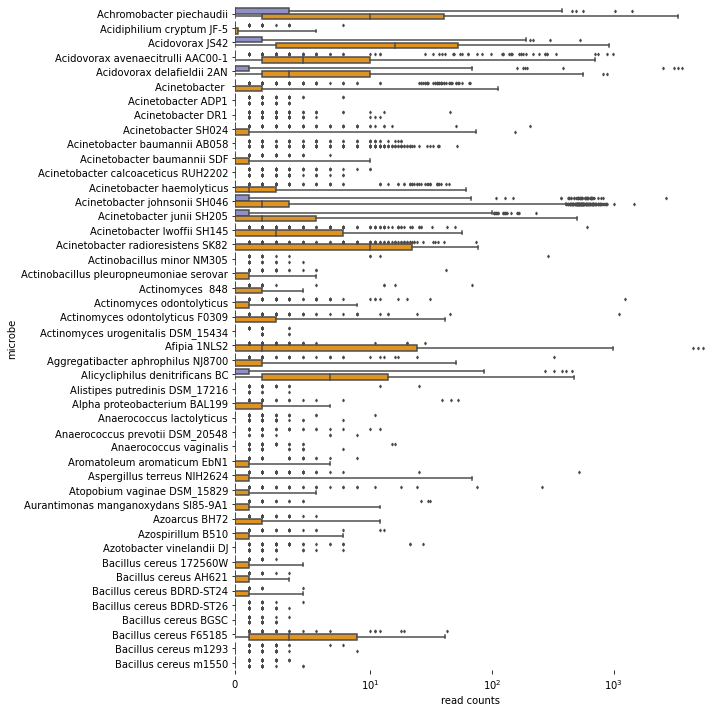

In [45]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df_melt, x='read counts', y='microbe', hue='in_batch', fliersize=2, whis=100)#, jitter=.2)

#sns.boxplot(data=df_melt[df_melt.in_batch=='0'], x='read counts', y='microbe', color='#D3D3D3', fliersize=2, whis=100)#, jitter=.2)
#sns.stripplot(data=df_melt[df_melt.in_batch!='0'], x='read counts', y='microbe', hue='in_batch', 
#              hue_order = sorted(list(np.unique(df_melt[df_melt.in_batch!='0'].in_batch.values))), jitter=.2)
abundance_plot_settings()
#plt.savefig('%s/virus_associated_with_batch.png' % fig_dir, 
#            transparent=True, bbox_inches='tight', format='png', dpi=500)

## Load / format data

In [2]:
bam_mappings = pd.read_csv(bam_mappings_file, sep='\t', index_col=1)
df_bacteria = pd.read_csv(bacteria_file, index_col=0)
df_virus  = pd.read_csv(virus_file, index_col=0)

df_virus['batch'] = bam_mappings.loc[[i.split(' ')[0] for i in df_virus.index]].sequencing_plate.values
df_virus['family'] = bam_mappings.loc[[i.split(' ')[0] for i in df_virus.index]].family.values
df_virus['type'] = bam_mappings.loc[[i.split(' ')[0] for i in df_virus.index]].bio_seq_source.values

df_bacteria['batch'] = bam_mappings.loc[[i.split(' ')[0] for i in df_bacteria.index]].sequencing_plate.values
df_bacteria['family'] = bam_mappings.loc[[i.split(' ')[0] for i in df_bacteria.index]].family.values
df_bacteria['type'] = bam_mappings.loc[[i.split(' ')[0] for i in df_bacteria.index]].bio_seq_source.values

In [3]:
bacteria_family_hits = pd.read_csv(bacteria_family_hits_file, index_col=0)
virus_family_hits = pd.read_csv(virus_family_hits_file, index_col=0)

# Filter to families in same batch/cell type
families_same_tech = df_virus[['family', 'type', 'batch']].groupby('family').aggregate(lambda x: len(set(x)))
families_to_keep = list(families_same_tech[(families_same_tech['batch']==1) & (families_same_tech['type']==1)].index)
df_bacteria = df_bacteria[[f in families_to_keep for f in df_bacteria.family]]
df_virus = df_virus[[f in families_to_keep for f in df_virus.family]]

# Set family hits to NA.
for i in virus_family_hits.iterrows():
    df_virus.loc[df_virus.family==i[1].family,i[1].microbe] = np.nan
for i in bacteria_family_hits.iterrows():
    df_bacteria.loc[df_bacteria.family==i[1].family,i[1].microbe] = np.nan

In [10]:
def GetHits(dataframe, family_microbes_to_skip=[]):
    sig_hits = []
    exog = pd.get_dummies(bam_mappings.loc[dataframe.index][['sequencing_plate', 'bio_seq_source', 'family']], drop_first=False).astype(float)
    #exog['sex'] = 0*exog['sex_numeric_2.0'] #- exog['sex_numeric_2.0']
    exog['type'] = exog['bio_seq_source_WB'] #- exog['bio_seq_source_LCL']
    #    pd.isna(bam_mappings.loc[exog.index]['derived_affected_status']) & (bam_mappings.loc[exog.index]['relationship']=='sibling')).values
    exog = exog.drop(set(['sex_numeric_1.0', 'sex_numeric_2.0', 'bio_seq_source_LCL', 'bio_seq_source_WB']).intersection(set(exog.columns)), axis=1)
    exog = sm.add_constant(exog)
    exog.columns = [c.replace('sequencing_plate_', '').replace('bio_seq_source_', '') for c in exog.columns]
    for c in dataframe.columns[:-3]:
        print(c)
        families_to_remove = []#set(family_microbes_to_skip[family_microbes_to_skip.microbe==c]['family'])
        data = dataframe[[f not in families_to_remove for f in dataframe['family']]][c]
        if sum(data)==0: 
            print('skipping', c)
            continue
        fit = smapi.GLM(endog=np.log(data+1), exog=exog[[f not in families_to_remove for f in dataframe['family']]]).fit()#, family=sm.families.Poisson()).fit()#.assign(intercept=0).fit()#, 'derived_affected_status']])
        params = fit.params.keys()
        coefs = fit.params.values
        pvals = fit.pvalues * len(dataframe.columns[:-3])
        pvals =  pvals * (len(params)-2)
        
        cell_type_idx = np.where(params=='type')[0][0]
        sex_idx = 0#np.where(params=='sex')[0][0]
        #asd_idx = np.where(params=='asd')[0][0]
        
        # Cell type.
        pval_LCL = pvals[cell_type_idx]
        pval_WB = pvals[cell_type_idx]
        coef_WB = coefs[cell_type_idx]
        coef_LCL = -1*coefs[cell_type_idx]
        
        # Sex.
        pval_male = pvals[sex_idx]
        pval_female = pvals[sex_idx]
        coef_male = -1#*coefs[sex_idx]
        coef_female = -1#coefs[sex_idx]
                
        coefs = np.array(list(coefs[(params!='type') & (params!='sex') & (params!='const') ]) + [coef_LCL, coef_WB, coef_male, coef_female])
        pvals = np.array(list(pvals[(params!='type') & (params!='sex') & (params!='const') ]) + [pval_LCL, pval_WB, pval_male, pval_female])
        params = np.array(list(params[(params!='type') & (params!='sex') & (params!='const')]) + ['LCL', 'WB', 'male', 'female'])
        
        hits = params[(coefs>0) & (pvals<.05)]
        new_coefs = coefs[(coefs>0) & (pvals<.05)]
        pvals = pvals[(coefs>0) & (pvals<.05)]
        if len(hits) == 0:
            continue
        for h,p,coef in zip(hits, pvals, new_coefs):
            sig_hits = sig_hits + [(c,h,p, coef)]
    return sig_hits
    #except: print(c, 'fail...')

In [34]:
dataframe = df_bacteria
exog = pd.get_dummies(bam_mappings.loc[dataframe.index][['sequencing_plate', 'bio_seq_source', 'family']], drop_first=False).astype(float)
#   pd.isna(bam_mappings.loc[exog.index]['derived_affected_status']) & (bam_mappings.loc[exog.index]['relationship']=='sibling')).values
#    exog = exog.drop(set(['sex_numeric_1.0', 'sex_numeric_2.0', 'bio_seq_source_LCL', 'bio_seq_source_WB']).intersection(set(exog.columns)), axis=1)
exog = sm.add_constant(exog)
exog.columns = [c.replace('sequencing_plate_', '').replace('bio_seq_source_', '') for c in exog.columns]
data = dataframe[dataframe.columns[0]]
fit = smapi.GLM(endog=np.log(data+1), exog=exog).fit()#, family=sm.families.Poisson()).fit()#.assign(intercept=0).fit()#, 'derived_affected_status']])


In [20]:
bacteria_hits =  GetHits(df_bacteria[df_bacteria.columns[-5:]])#, virus_family_hits)
#virus_hits = GetHits(df_virus[df_virus.columns[-5:]])#, virus_family_hits)

Yersinia pestis biovar
Zymomonas mobilismobilis NCIB_11163


In [22]:
bacteria_hits

[('Yersinia pestis biovar',
  'family_AU0711',
  1.4778688566275146e-07,
  0.7708574627192583),
 ('Yersinia pestis biovar',
  'family_AU1353',
  2.8259702159888855e-09,
  0.42842676219967046),
 ('Zymomonas mobilismobilis NCIB_11163',
  'family_AU2065',
  0.00026308037674526124,
  0.49232875426538514),
 ('Zymomonas mobilismobilis NCIB_11163',
  'family_AU2455',
  0.0004531086257614725,
  0.3815202251867968)]

In [6]:
virus_hits_LCL = [h for h in virus_hits if h[1]=='LCL']
virus_hits_WB = [h for h in virus_hits if h[1]=='WB']
virus_hits_male = [h for h in virus_hits if h[1]=='male']
virus_hits_female = [h for h in virus_hits if h[1]=='female']
virus_hits_batch = {h for h in virus_hits if 'MTR' in h[1]}
for i in [virus_hits_LCL,virus_hits_WB,virus_hits_male,virus_hits_female,virus_hits_batch,]:
    print(len({b[0] for b in i}))

1
4
0
0
8


In [24]:
bacteria_hits_LCL = [h for h in bacteria_hits if h[1]=='LCL']
bacteria_hits_WB = [h for h in bacteria_hits if h[1]=='WB']
bacteria_hits_male = [h for h in bacteria_hits if h[1]=='male']
bacteria_hits_female = [h for h in bacteria_hits if h[1]=='female']
bacteria_hits_batch = {h for h in bacteria_hits if 'MTR' in h[1]}
bacteria_hits_filt_batch = {h for h in bacteria_hits_batch if np.sum(df_bacteria[df_bacteria.batch==h[1]][h[0]]>0)>5}
for i in [bacteria_hits_LCL,bacteria_hits_WB,bacteria_hits_male,bacteria_hits_female,bacteria_hits_batch, bacteria_hits_filt_batch]:
    print(len({b[0] for b in i}))

6
76
0
0
108
99


In [8]:
#for b,_,_,_ in bacteria_hits_female:
#    male = pd.DataFrame(df_bacteria[b][bam_mappings.loc[df_bacteria.index]['sex_numeric']=='1.0'])
#    male['sex'] = 'male'
#    female = pd.DataFrame(df_bacteria[b][bam_mappings.loc[df_bacteria.index]['sex_numeric']=='2.0'])
#    female['sex'] = 'female'
#    sns.violinplot(data=pd.concat([male, female]), x='sex', y=b)
#    plt.show()
    
#for b,_,_,_ in virus_hits_male:
#    male = pd.DataFrame(df_virus[b][bam_mappings.loc[df_virus.index]['sex_numeric']=='1.0'])
#    male['sex'] = 'male'
#    female = pd.DataFrame(df_virus[b][bam_mappings.loc[df_virus.index]['sex_numeric']=='2.0'])
#    female['sex'] = 'female'
#    sns.violinplot(data=pd.concat([male, female]), x='sex', y=b)
#    plt.show()

# Plotting

In [11]:
hit_microbes_batch = list({i[0] for i in virus_hits_batch})
df_melt = pd.melt(df_virus[hit_microbes_batch + ['batch', 'family']].reset_index(), id_vars=['sample', 'family', 'batch'])
df_melt['in_batch'] = '0'
for microbe,b,_,_ in virus_hits_batch:
    df_melt.loc[(df_melt.batch==b) & (df_melt.variable==microbe),'in_batch']=b
df_melt.rename(columns={'variable': 'microbe', 'value': 'read counts'}, inplace=True)
df_melt = df_melt.sort_values('microbe')

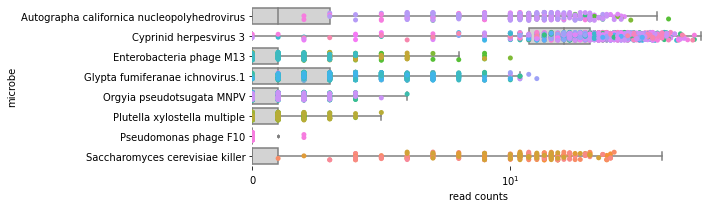

In [12]:
plt.figure(figsize=(10,3))
sns.boxplot(data=df_melt[df_melt.in_batch=='0'], x='read counts', y='microbe', color='#D3D3D3', fliersize=2, whis=100)#, jitter=.2)
sns.stripplot(data=df_melt[df_melt.in_batch!='0'], x='read counts', y='microbe', hue='in_batch', 
              hue_order = sorted(list(np.unique(df_melt[df_melt.in_batch!='0'].in_batch.values))), jitter=.2)
abundance_plot_settings()
plt.savefig('%s/virus_associated_with_batch.png' % fig_dir, 
            transparent=True, bbox_inches='tight', format='png', dpi=500)

# Bacteria

In [13]:
df_bacteria['sample'] = df_bacteria.index
hit_microbes_WB = list({i[0] for i in bacteria_hits_WB})
df_melt = pd.melt(df_bacteria[hit_microbes_WB + ['type', 'family']].reset_index(), id_vars=['index', 'family', 'type'])
df_melt.rename(columns={'variable': 'microbe', 'value': 'read counts'}, inplace=True)
df_melt = df_melt.sort_values('microbe')

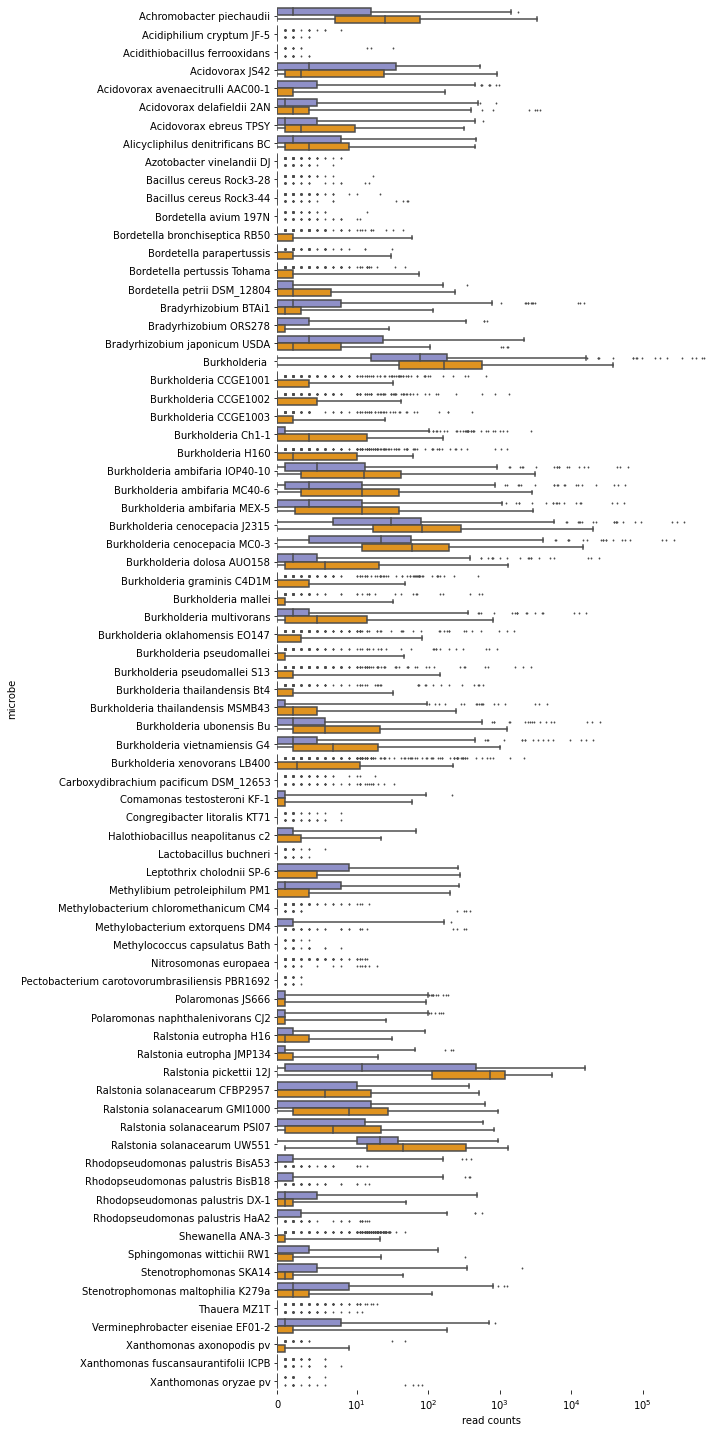

In [14]:
plt.figure(figsize=(10,20))
sns.boxplot(data=df_melt, x='read counts', y='microbe', hue='type', hue_order=['LCL','WB'], fliersize=1, whis=100)#, jitter=.2)
abundance_plot_settings()
plt.savefig('%s/bacteria_associated_with_WB.png' % fig_dir, 
            transparent=True, bbox_inches='tight', format='png', dpi=500)

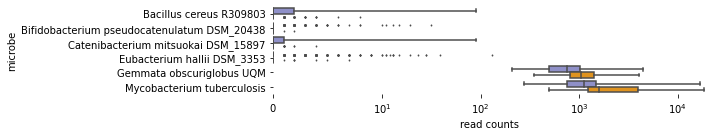

In [15]:
hit_microbes_LCL = list({i[0] for i in bacteria_hits_LCL})
df_melt = pd.melt(df_bacteria[hit_microbes_LCL + ['type', 'family']].reset_index(), id_vars=['index', 'family', 'type'])
df_melt.rename(columns={'variable': 'microbe', 'value': 'read counts'}, inplace=True)
plt.figure(figsize=(10,2))
df_melt = df_melt.sort_values('microbe')
sns.boxplot(data=df_melt, x='read counts', y='microbe', hue='type', hue_order=['LCL','WB'], fliersize=1, whis=100)
abundance_plot_settings()
plt.savefig('%s/bacteria_associated_with_LCL.png' % fig_dir, 
            transparent=True, bbox_inches='tight', format='png', dpi=500)

In [16]:
#sorted_bacteria_hits_batch = sorted(list(bacteria_hits_batch), key=lambda x: x[2])[:100]
hit_microbes_batch = list({i[0] for i in bacteria_hits_batch})
df_melt = pd.melt(df_bacteria[hit_microbes_batch + ['batch', 'family']].reset_index(), id_vars=['index', 'family', 'batch'])
df_melt['in_batch'] = '0'
for microbe,b,_,_ in bacteria_hits_batch:
    df_melt.loc[(df_melt.batch==b) & (df_melt.variable==microbe),'in_batch']=b
df_melt = pd.concat([df_melt[df_melt.in_batch!='0'], df_melt[df_melt.in_batch=='0'].iloc[::10]])
df_melt.rename(columns={'variable': 'microbe', 'value': 'read counts'}, inplace=True)
df_melt = df_melt.sort_values('microbe')

In [21]:
df_melt[(df_melt.in_batch!='0') & (df_melt['read counts']!=0)]

,index,family,batch,microbe,read counts,in_batch
78461,03C15854,AU0037,MTR-00935,Acetobacter pasteurianus IFO,1.0,MTR-00935
78642,03C16417,AU0665,MTR-00935,Acetobacter pasteurianus IFO,3.0,MTR-00935
217186,07C70261,AU1864,MTR-00931,Acinetobacter ADP1,1.0,MTR-00931
217485,08C78166,AU1756,MTR-01017,Acinetobacter ADP1,2.0,MTR-01017
217185,07C70260,AU1864,MTR-00931,Acinetobacter ADP1,3.0,MTR-00931
...,...,...,...,...,...,...
24945,03C16003,AU0027,MTR-00009,Xylella fastidiosa Dixon,2.0,MTR-00009
24941,03C15999,AU0227,MTR-00009,Xylella fastidiosa Dixon,4.0,MTR-00009
24931,03C15972,AU0386,MTR-00009,Xylella fastidiosa Dixon,2.0,MTR-00009
24930,03C15971,AU0386,MTR-00009,Xylella fastidiosa Dixon,3.0,MTR-00009


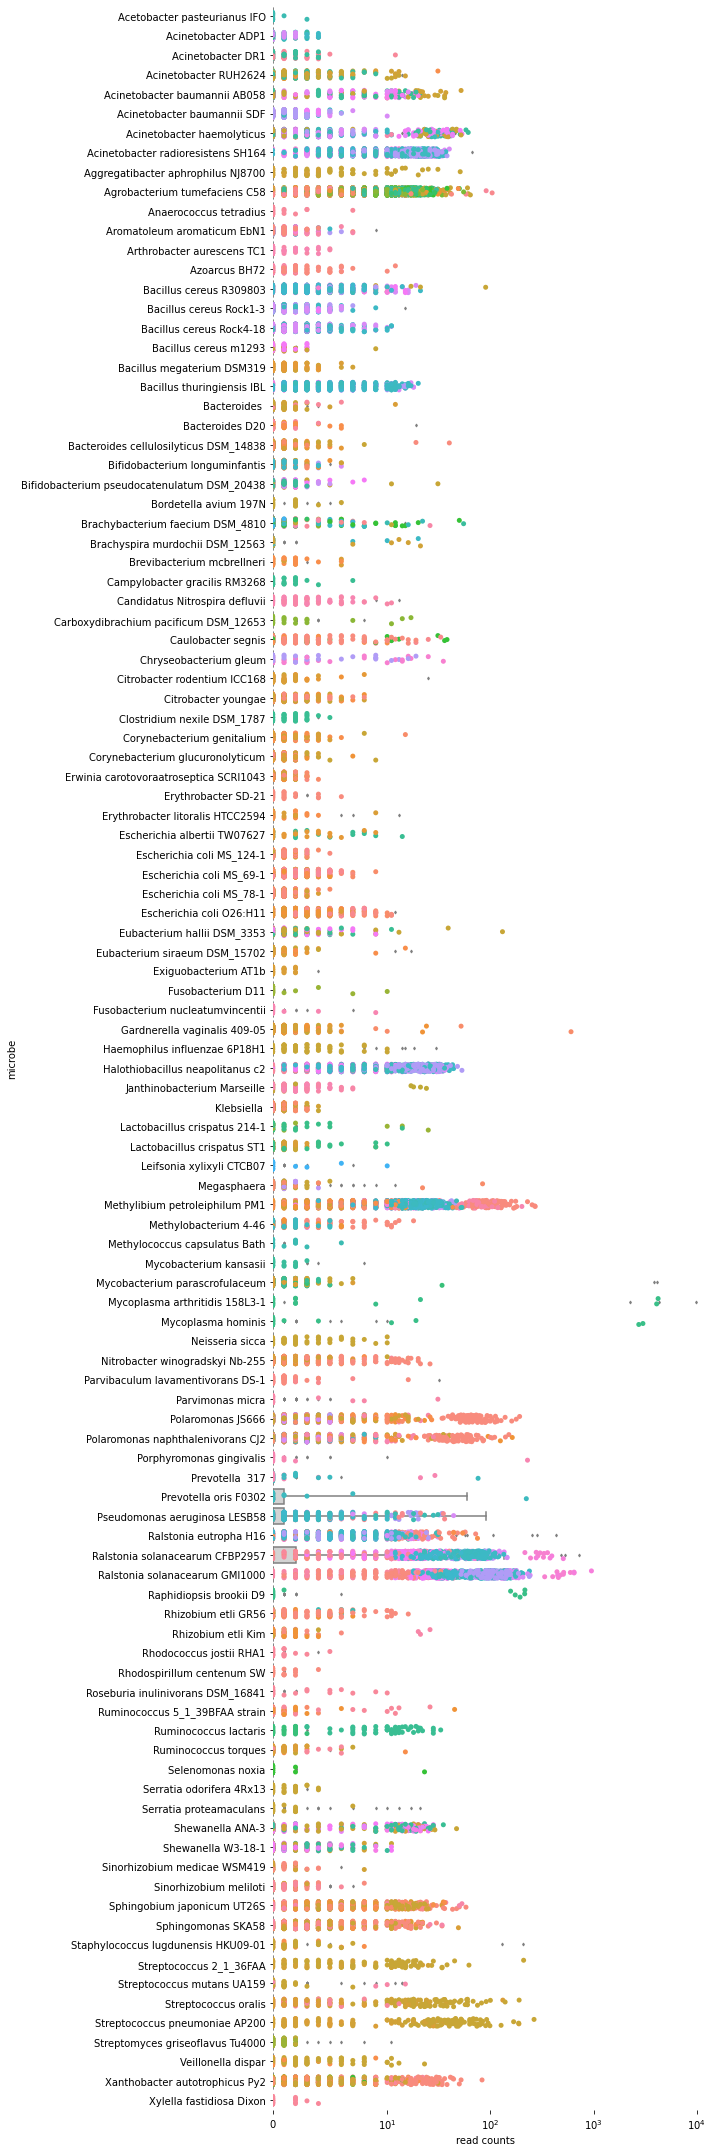

In [26]:
plt.figure(figsize=(10,30))
sns.boxplot(data=df_melt[df_melt.in_batch=='0'], x='read counts', y='microbe', color='#D3D3D3', fliersize=2, whis=100)
sns.stripplot(data=df_melt[df_melt.in_batch!='0'], x='read counts', y='microbe', hue='in_batch', 
              hue_order = sorted(list(np.unique(df_melt[df_melt.in_batch!='0'].in_batch.values))), jitter=.2)
abundance_plot_settings()
plt.savefig('%s/bacteria_associated_with_batch.png' % fig_dir, 
            transparent=True, bbox_inches='tight', format='png', dpi=500)

# OLD

In [101]:
hit_microbes_WB = list(fs_df[fs_df['WB']<(.05/len(fs_df))].index)
print(len(hit_microbes_WB), 'associated w/WB')
hit_microbes_LCL = list(fs_df[fs_df['LCL']<(.05/len(fs_df))].index)
print(len(hit_microbes_LCL), 'associated w/LCL')

idx_batch = np.where(fs_df.drop(['WB', 'LCL'], axis=1)<(.05/(len(fs_df))))
hits_batch = [(bacteria, batch) for bacteria, batch in zip(fs_df.index[idx_batch[0]], fs_df.columns[idx_batch[1]])]
hit_microbes_batch = list({v[0] for v in hits_batch})
print(len(hit_microbes_batch), 'associated w/batch')

89 associated w/WB
47 associated w/LCL
273 associated w/batch


In [841]:
from scipy.stats import chi2_contingency
count_table = pd.pivot_table(bam_mappings, columns=['sequencing_plate'], values='FatherID',
                    index=['sex_numeric'], aggfunc=len, fill_value=0)
print(chi2_contingency(count_table, lambda_="log-likelihood")[:3],)

(297.3135384536702, 1.0348114089528473e-35, 53)


In [8]:
hit_microbes_LCL = list(fs_df.sort_values(['LCL'])[:25].index)
print(len(hit_microbes_LCL))

hit_microbes_WB = list(fs_df.sort_values(['WB'])[:25].index)
print(len(hit_microbes_WB))

hit_microbes_batch = pd.DataFrame()
hit_microbes_batch['min'] = fs_df.drop('WB', axis=1).min(axis=1)
hit_microbes_batch['argmin'] = fs_df.drop('WB', axis=1).apply(lambda x: fs_df.columns[np.argmin(x)],axis=1)
hit_microbes_batch = hit_microbes_batch.sort_values('min')[:100]
#idx_batch = fs_df.drop('WB', axis=1).min(axis=1).sort_values()[:50]
hits_batch = [(virus, batch) for virus, batch in zip(hit_microbes_batch.index, hit_microbes_batch['argmin'].values)]
hit_microbes_batch = list({v[0] for v in hits_batch})
print(len(hit_microbes_batch))

25
25
100


In [12]:
# Top 25 bacteria associated with LCL.
df_bacteria['sample']=df_bacteria.index
df_bacteria.index = df_bacteria['sample']
df_melt = pd.melt(df_bacteria[hit_microbes_LCL + ['type', 'family']].reset_index(), id_vars=['sample', 'family', 'type'])
df_melt.rename(columns={'variable': 'microbe', 'value': 'read counts'}, inplace=True)
df_melt = df_melt.sort_values('microbe')
# Skip samples from family associated microbes
skip_microbes = {(i,j) for i,j in zip(bacteria_family_hits.family, virus_family_hits.microbe)} 
df_melt = df_melt[[(i,j) not in skip_microbes for i,j in zip(df_melt.family.values, df_melt.microbe.values)]]


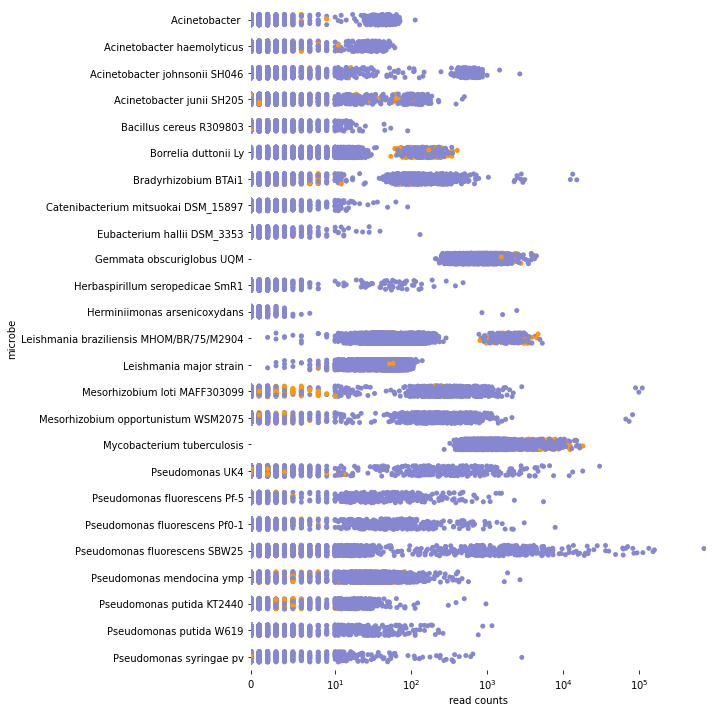

In [16]:
# Top 25 bacteria associated with LCL.
df_bacteria['sample']=df_bacteria.index
df_bacteria.index = df_bacteria['sample']
df_melt = pd.melt(df_bacteria[hit_microbes_LCL + ['type', 'family']].reset_index(), id_vars=['sample', 'family', 'type'])
df_melt.rename(columns={'variable': 'microbe', 'value': 'read counts'}, inplace=True)
df_melt = df_melt.sort_values('microbe')

# Skip samples from family associated microbes
skip_microbes = {(i,j) for i,j in zip(bacteria_family_hits.family, virus_family_hits.microbe)} 
df_melt = df_melt[[(i,j) not in skip_microbes for i,j in zip(df_melt.family.values, df_melt.microbe.values)]]

plt.figure(figsize=(10,10))
sns.stripplot(data=df_melt, x='read counts', y='microbe', hue='type', hue_order=['LCL','WB'],jitter=.2)
abundance_plot_settings()
plt.savefig('%s/bacteria_associated_with_LCL.png' % fig_dir, 
            transparent=True, bbox_inches='tight', format='png', dpi=500)

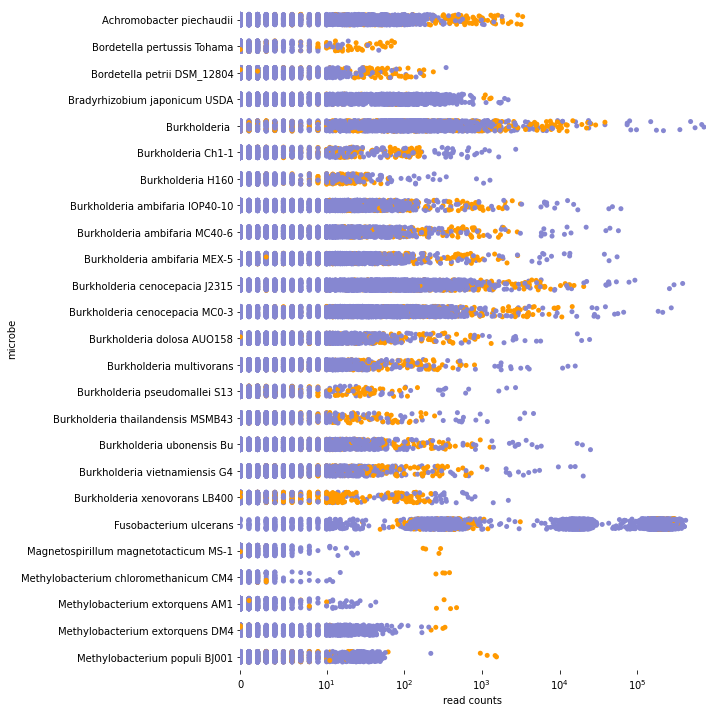

In [19]:
# Top 25 bacteria associated with WB.
df_melt = pd.melt(df_bacteria[hit_microbes_WB + ['type', 'family']].reset_index(), id_vars=['sample', 'family', 'type'])
df_melt.rename(columns={'variable': 'microbe', 'value': 'read counts'}, inplace=True)
df_melt = df_melt.sort_values('microbe')

# Skip samples from family associated microbes
skip_microbes = {(i,j) for i,j in zip(bacteria_family_hits.family, virus_family_hits.microbe)} 
df_melt = df_melt[[(i,j) not in skip_microbes for i,j in zip(df_melt.family.values, df_melt.microbe.values)]]

plt.figure(figsize=(10,10))
sns.stripplot(data=df_melt, x='read counts', y='microbe', hue='type', hue_order=['LCL','WB'],jitter=.2)
abundance_plot_settings()
plt.savefig('%s/bacteria_associated_with_WB.png' % fig_dir, 
            transparent=True, bbox_inches='tight', format='png', dpi=500)

In [10]:
df_bacteria['sample']=df_bacteria.index

In [11]:
# Top 100 bacteria associated with batch.
df_melt = pd.melt(df_bacteria[hit_microbes_batch + ['batch', 'family', 'sample']].reset_index(), id_vars=['sample', 'family', 'batch'])
df_melt['in_batch'] = '0'
for microbe,b in hits_batch:
    df_melt.loc[(df_melt.batch==b) & (df_melt.variable==microbe),'in_batch']=b
df_melt.rename(columns={'variable': 'microbe', 'value': 'read counts'}, inplace=True)
df_melt = df_melt.sort_values('microbe')

In [18]:
len(pd.concat([df_melt[df_melt.in_batch=='0'].iloc[::10]]))#, df_melt[df_melt.in_batch=='0'].iloc[::5]]))

40789

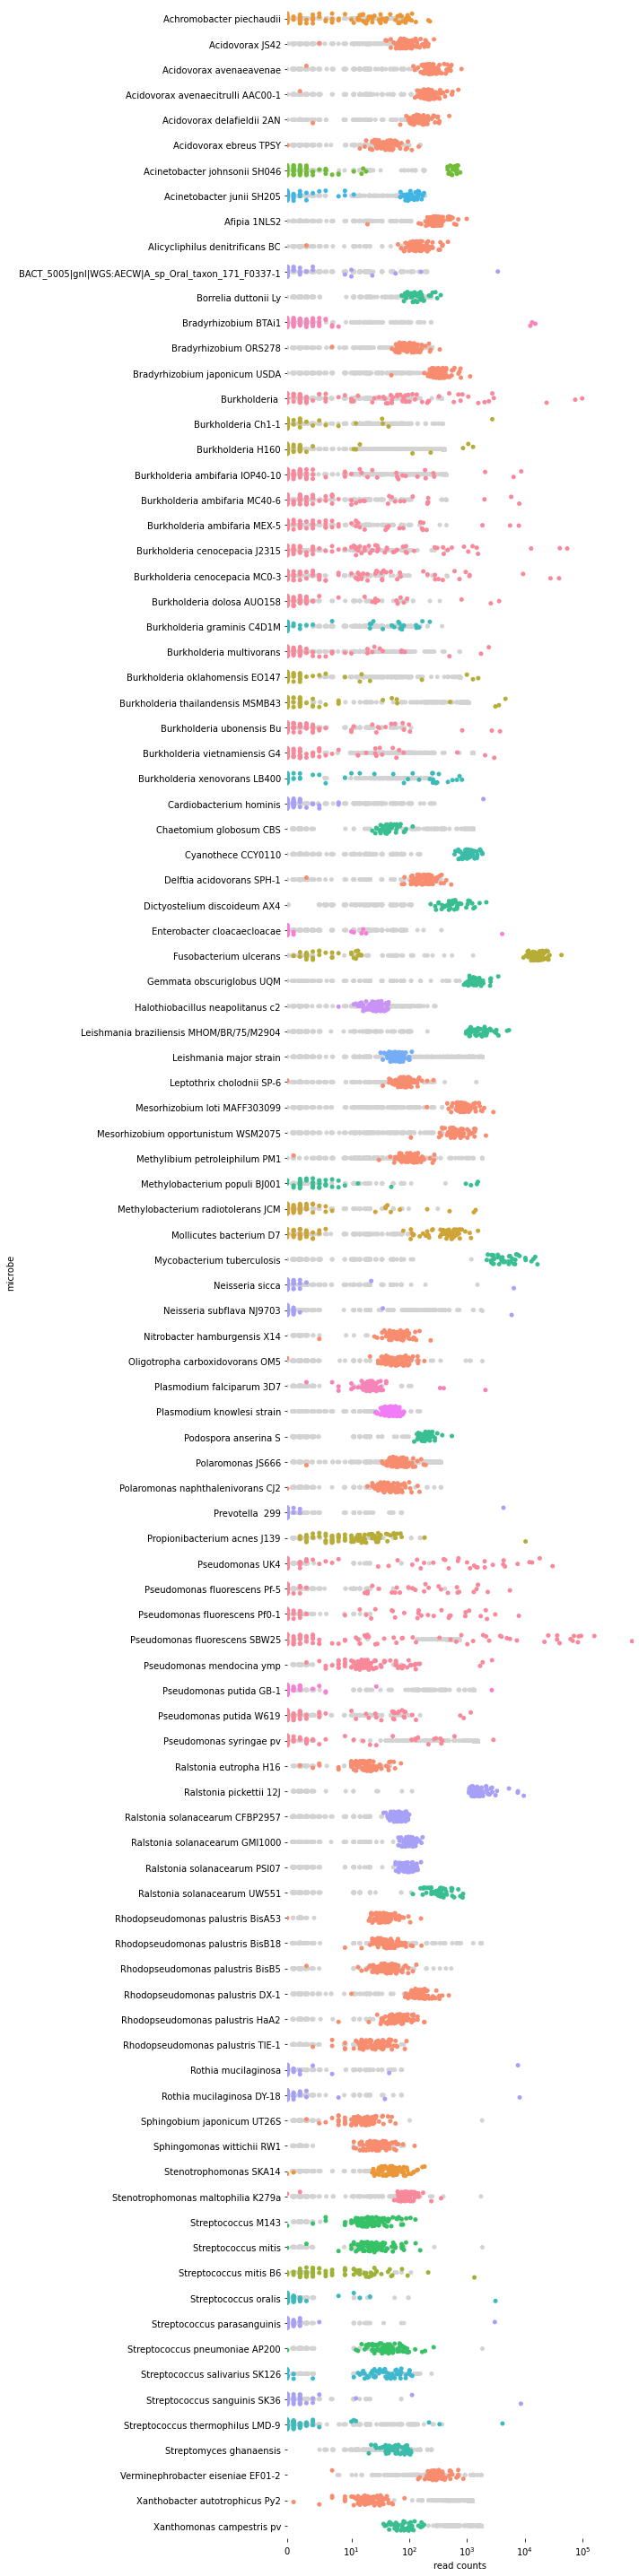

In [19]:
df_melt = pd.concat([df_melt[df_melt.in_batch!='0'], df_melt[df_melt.in_batch=='0'].iloc[::10]]) # We don't need ALLLL the grey dots.

# Don't show family associated microbes
skip_microbes = {(i,j) for i,j in zip(bacteria_family_hits.family, bacteria_family_hits.microbe)} 
df_melt = df_melt[[(i,j) not in skip_microbes for i,j in zip(df_melt.family.values, df_melt.microbe.values)]]

plt.figure(figsize=(10,40))
sns.stripplot(data=df_melt[df_melt.in_batch=='0'], x='read counts', y='microbe', color='#D3D3D3', jitter=.2)
sns.stripplot(data=df_melt[df_melt.in_batch!='0'], x='read counts', y='microbe', hue='in_batch', 
              hue_order = sorted(list(np.unique(df_melt[df_melt.in_batch!='0'].in_batch.values))), jitter=.2)
abundance_plot_settings()
plt.savefig('%s/bacteria_associated_with_batch.png' % fig_dir, 
            transparent=True, bbox_inches='tight', format='png', dpi=500)

In [95]:
# Top 100 bacteria.
idx_batch = np.where(fs_df.drop('WB', axis=1)<(.05e-200/(len(fs_df)*(np.shape(fs_df)[1]-1))))
hits_batch = [(bacteria, batch) for bacteria, batch in zip(fs_df.index[idx_batch[0]], fs_df.columns[idx_batch[1]])]
hit_microbes_batch = list({v[0] for v in hits_batch})
print(len(hit_microbes_batch))

df_melt = pd.melt(df_bacteria[hit_microbes_batch + ['batch', 'family']].reset_index(), id_vars=['index', 'family', 'batch'])
df_melt['in_batch'] = '0'
for microbe,b in hits_batch:
    df_melt.loc[(df_melt.batch==b) & (df_melt.variable==microbe),'in_batch']=b
df_melt.rename(columns={'variable': 'microbe', 'value': 'read counts'}, inplace=True)
df_melt.to_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/df_melt_bacteria_batch_associated.csv')

100


Made bacteria associated with batch abundances with:

```/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/src/bacteria_associated_with_batch.sh```